# Two Cities, One Disease

by John Salter-Cid


<img src="images/mosquito.jpg" width="300" height="150">

Dengue Fever is no joke. Classified as neglected tropical disease by the WHO, Dengue quietly kills roughly 1,500 people a year and infecting an estimated 100 million people each year. Unfortunately, the only vaccine, Dengvaxia, is currently under significant controversy due to evidence it can increase severe infection in some people and, also, only recommended for those who have previously had dengue fever. Therfore, until a more robust vaccine can be created, the main strategy against the disease remains vector control and early infection detection. This project aims to shed some light on the second point.

This project works towards DrivenData's [Dengue Fever](https://www.drivendata.org/competitions/44/) competition. As this disease is spread via mosquitoes and transmission is heavily linked to variables such as temperature and precipitation, this project focuses on using climate data to predict local epidemics of dengue fever. More specifically, this project will focus on data from two cities, San Juan in Puerto Rico and Iquitos in Peru. The ultimate goal here is to see if, with the data given, can I predict the number of dengue fever cases reported each week in the two cities. Let's jump in!

<table><tr><td><img src='images/San Juan.jpg' width="300" height="150"></td><td><img src='images/iquitos-peru.jpg' width="300" height="150"></td></tr></table>

## Part 1: Set Up

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from IPython.display import display_html

# I use this function to help me visualize things side by side. Helps me from creating really lengthy notebooks.

def display_side_by_side(*args):
    html_str=''
    for table in args:
        html_str+=table.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
from warnings import filterwarnings

#filterwarnings('ignore')

## Part 2: Loading and Initial Exploration

The data was provided in two CSV files, on with the features and one with the labels. We will load them here.

In [16]:
feat_train = pd.read_csv('dengue_features_train.csv', index_col = [0,1,2], parse_dates = ['week_start_date'])
label_train = pd.read_csv("dengue_labels_train.csv", index_col =[0,1,2])

In [17]:
# For now, we are going to leave the 'week_start_date' column out of things as it is the only non-float data type here
feat_train2 = feat_train.drop('week_start_date', axis=1)

We are going to seperate the San Juan and Iquitos data to train models on them sepeartely. I am assuming that what is true for one city may not be true for the other.

In [18]:
sj_feat_train = feat_train2.loc['sj']
iq_feat_train = feat_train2.loc['iq']

sj_label_train = label_train.loc['sj']
iq_label_train = label_train.loc['iq']

In [19]:
sj_feat_train.head(3)

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  station_min_temp_c  station_precip_mm
year weekofyear                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1990 18          0.12260  0.103725  0.198483  0.177617                 12.42             297.572857             297.742857                   292.414286                      299.8                      295.9                            32.00                             73.365714                         12.42                              14.012857           2.628571           25.442857                 6.900000                29.4                20.0               16.0
     19          0.16990  0.142175  0.162357  0.155486                 22.82             298.211429             298.442857                   293.951429                      300.9                      296.4                            17.94                             77.368571                         22.82                              15.372857           2.371429           26.714286                 6.371429                31.7                22.2                8.6
     20          0.03225  0.172967  0.157200  0.170843                 34.54             298.781429             298.878571                   295.434286                      300.5                      297.3                            26.10                             82.052857                         34.54                              16.848571           2.300000           26.714286                 6.485714                32.2                22.8               41.4

In [20]:
iq_feat_train.head(3)

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  station_min_temp_c  station_precip_mm
year weekofyear                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2000 26          0.192886  0.132257  0.340886  0.247200                 25.41             296.740000             298.450000                   295.184286                      307.3                      293.1                            43.19                             92.418571                         25.41                              16.651429           8.928571                26.4                10.775000                32.5                20.7                3.0
     27          0.216833  0.276100  0.289457  0.241657                 60.61             296.634286             298.428571                   295.358571                      306.6                      291.1                            46.00                             93.581429                         60.61                              16.862857          10.314286                26.9                11.566667                34.0                20.8               55.6
     28          0.176757  0.173129  0.204114  0.128014                 55.52             296.415714             297.392857                   295.622857                      304.5                      292.6                            64.77                             95.848571                         55.52                              17.120000           7.385714                26.8                11.466667                33.0                20.7               38.1

In [21]:
print("The shape of the San Juan dataframe is {} and the Iquitos dataframe is {}.".format(sj_feat_train.shape, iq_feat_train.shape))

The shape of the San Juan dataframe is (936, 20) and the Iquitos dataframe is (520, 20).


In [22]:
sj_feat_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 936 entries, (1990, 18) to (2008, 17)
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ndvi_ne                                745 non-null    float64
 1   ndvi_nw                                887 non-null    float64
 2   ndvi_se                                917 non-null    float64
 3   ndvi_sw                                917 non-null    float64
 4   precipitation_amt_mm                   927 non-null    float64
 5   reanalysis_air_temp_k                  930 non-null    float64
 6   reanalysis_avg_temp_k                  930 non-null    float64
 7   reanalysis_dew_point_temp_k            930 non-null    float64
 8   reanalysis_max_air_temp_k              930 non-null    float64
 9   reanalysis_min_air_temp_k              930 non-null    float64
 10  reanalysis_precip_amt_kg_per_m2        930 non-null    flo

In [23]:
iq_feat_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 520 entries, (2000, 26) to (2010, 25)
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ndvi_ne                                517 non-null    float64
 1   ndvi_nw                                517 non-null    float64
 2   ndvi_se                                517 non-null    float64
 3   ndvi_sw                                517 non-null    float64
 4   precipitation_amt_mm                   516 non-null    float64
 5   reanalysis_air_temp_k                  516 non-null    float64
 6   reanalysis_avg_temp_k                  516 non-null    float64
 7   reanalysis_dew_point_temp_k            516 non-null    float64
 8   reanalysis_max_air_temp_k              516 non-null    float64
 9   reanalysis_min_air_temp_k              516 non-null    float64
 10  reanalysis_precip_amt_kg_per_m2        516 non-null    flo

<br></br>
We appear to have some nulls. Given the that these are time-series, it woill be rather safe to fill those values with a forward fill approach.
<br></br><br></br>

In [24]:
sj_feat_train = sj_feat_train.fillna(method='ffill')
iq_feat_train = iq_feat_train.fillna(method='ffill')

print("The number of nulls in the... \
      \n San Juan dataframe: {} \
      \n Iquitos dataframe : {}".format(sj_feat_train.isnull().values.sum(), iq_feat_train.isnull().values.sum()))

The number of nulls in the...       
 San Juan dataframe: 0       
 Iquitos dataframe : 0


<br></br>
Now let's plot the features to see what we are dealing with here. Upon intial inspection, I've noticed that these features vary greatly in distribution. I have, therefore, normalized them for easier inspection.
<br></br><br></br>

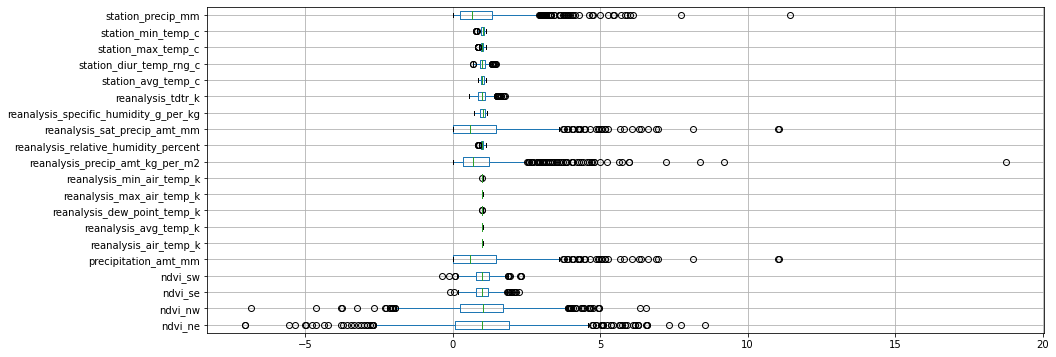

In [25]:
plt.figure(figsize=(15,6))
normalized_sj_feat = sj_feat_train/sj_feat_train.mean()
normalized_sj_feat.boxplot(vert=False)

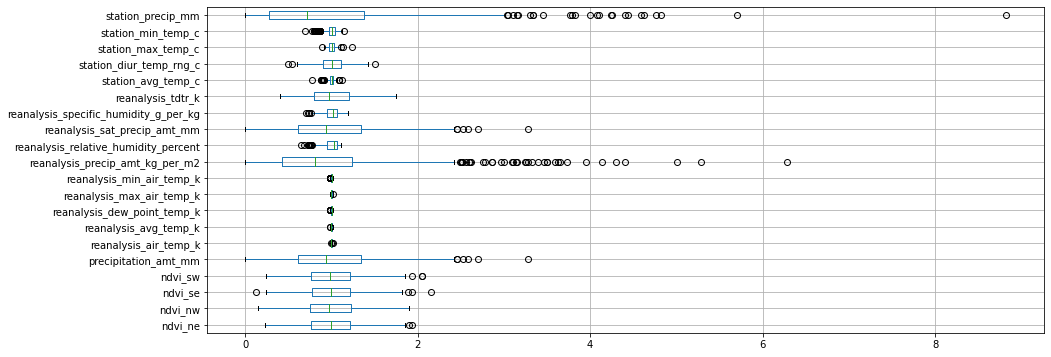

In [26]:
plt.figure(figsize=(15,6))
normalized_iq_feat = iq_feat_train/iq_feat_train.mean()
normalized_iq_feat.boxplot(vert=False)

<br></br>
Right away we can see that these cities have quite different climates. Our initial hunch that these would be different already appears to be correct and modellling these two separately appears to be the right call. Now, let's see how their cases data matches up (labels)
<br></br><br></br>

In [27]:
display_side_by_side(iq_label_train.describe(),sj_label_train.describe())

,total_cases
count,520.000000
mean,7.565385
std,10.765478
min,0.000000
25%,1.000000
50%,5.000000
75%,9.000000
max,116.000000
,total_cases
count,936.000000


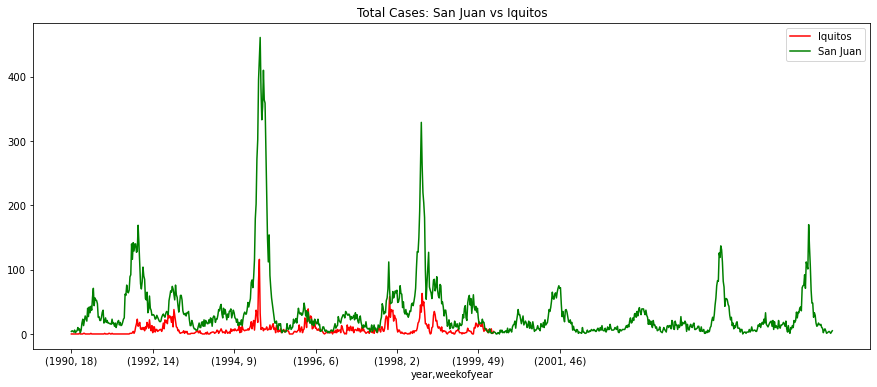

In [28]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('Total Cases: San Juan vs Iquitos')
iq_label_train.total_cases.plot.line(ax=ax, color='r', legend=True, label="Iquitos")
sj_label_train.total_cases.plot.line(ax=ax, color='g', legend=True, label="San Juan")


Text(0.5, 1.0, 'Iquitos Total Cases')

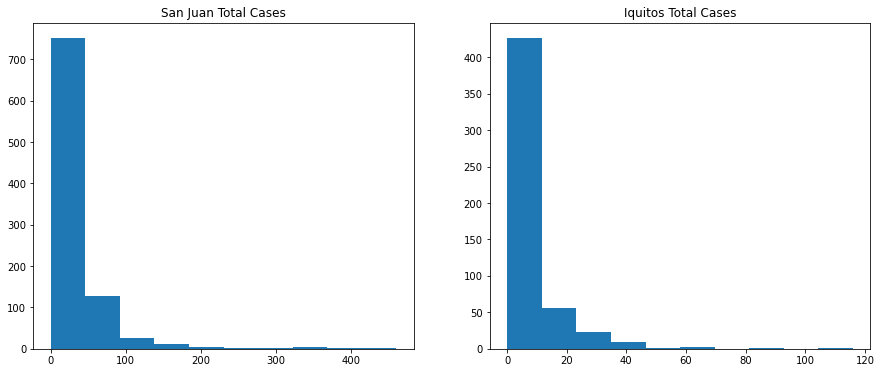

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15, 6))
axs[0].hist(sj_label_train.total_cases)
axs[0].set_title("San Juan Total Cases")
axs[1].hist(iq_label_train.total_cases)
axs[1].set_title("Iquitos Total Cases")

<br></br>
### By looking at the summary statistics of the label dataframes, the line chart, and the histograms, we see that, indeed, these cities have very different label distributions! 

Interestingly, we see that the variances and means of the two cities are quite different:

##### San Juan: 
mean = 34.181

var = 2640.045
##### Iquitos:
mean = 7.565

var = 115.896


Also, we see from the histograms that these distributions are both skewed heavily to the right (positively skewed) and that we have a high occurance of 0's. With this information, we can better choose what model we should try first!
<br/><br/>

## Part 3: Choosing which model to try first
<br></br>
Given that we are working with a target variable that is a discrete count (of total cases), we are going to be utilizing regression techniques to make count predictions. To understand which models we should try first, it is important to understand a bit of theory. For a clear and very concise explanation of which regression models work for discrete count regression models, I recommend reading [this post](https://www.theanalysisfactor.com/regression-models-for-count-data/) by Karen Grace-Martin (outlined below).


"One of the main assumptions of linear models such as linear regression and analysis of variance is that the residual errors follow a normal distribution. To meet this assumption when a continuous response variable is skewed, a transformation of the response variable can produce errors that are approximately normal. Often, however, the response variable of interest is categorical or discrete, not continuous. In this case, a simple transformation cannot produce normally distributed errors.

#### A common example is when the response variable is the counted number of occurrences of an event (our case). 

The distribution of counts is discrete, not continuous, and is limited to non-negative values. 

#### There are two problems with applying an ordinary linear regression model to these data. 

First, many distributions of count data are positively skewed (seen in the histograms above) with many observations in the data set having a value of 0 (something we can also see in the charts above). The high number of 0’s in the data set prevents the transformation of a skewed distribution into a normal one. Second, it is quite likely that the regression model will produce negative predicted values, which are theoretically impossible.

An example of a regression model with a count response variable is the prediction of the number of times a person perpetrated domestic violence against his or her partner in the last year based on whether he or she had witnessed domestic violence as a child and who the perpetrator of that violence was. Because many individuals in the sample had not perpetrated violence at all, many observations had a value of 0, and any attempts to transform the data to a normal distribution failed.

#### An alternative is to use a Poisson regression model or one of its variants. 

These models have a number of advantages over an ordinary linear regression model, including a skew, discrete distribution, and the restriction of predicted values to non-negative numbers. A Poisson model is similar to an ordinary linear regression, with two exceptions. First, it assumes that the errors follow a Poisson, not a normal, distribution (for those seeking more information on Poisson distributions, I found [Khan Academy's video](https://www.khanacademy.org/math/statistics-probability/random-variables-stats-library/poisson-distribution/v/poisson-process-1) helpful when I was first learning). Second, rather than modeling Y as a linear function of the regression coefficients, it models the natural log of the response variable, ln(Y), as a linear function of the coefficients.

#### However, the Poisson model assumes that the mean and variance of the errors are equal. 

But usually in practice the variance of the errors is larger than the mean (our case again!). When the variance is larger than the mean, there are two extensions of the Poisson model that work well. In the over-dispersed Poisson model, an extra parameter is included which estimates how much larger the variance is than the mean. This parameter estimate is then used to correct for the effects of the larger variance on the p-values. 

#### An alternative is a negative binomial model. 

The negative binomial distribution is a form of the Poisson distribution in which the distribution’s parameter is itself considered a random variable. The variation of this parameter can account for a variance of the data that is higher than the mean (something that will be very useful in our case).

A negative binomial model proved to fit well for the domestic violence data described above. Because the majority of individuals in the data set perpetrated 0 times, but a few individuals perpetrated many times, the variance was over 6 times larger than the mean. Therefore, the negative binomial model was clearly more appropriate than the Poisson."

#### Given that our dataset has a variance that is much higher than the mean and is skewed to the right heavily, we will try out the Negative Binomial Regression.

<br></br>
## Part 4: Building the model and setting the benchmark
As a general practice, I like to build a basic model before I begin tinkering with features, parameters, or whatever else. This lets me set a benchmark before I dive in and try to extract every ounce of predictive power that a dataset has to offer. 

In [189]:
#Importing the relevant packages

SEED = 99
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler

In [164]:
# First, let's create some functions that will allow us to process things a bit 
# quicker (especially if we decide to change things up later - which we will)

def pull_month(m):
    return int(m[5:7])


def process(feat_df_path, 
            labels_df_path = None,
            features = feat_train.columns,
            fill_method='ffill', 
            drop_date=True,
            standardize = True,
            remove_outliers=False):
    
    # load data and set index
    df = pd.read_csv(feat_df_path, index_col=[0, 1, 2])
    
    # select features
    features = features
    df = df[features]
    
    #months = df.week_start_date.apply(pull_month)
    
    if drop_date:
        df = df.drop(['week_start_date'], axis=1)
        
    # fill missing values
    df = df.fillna(method=fill_method)

    #if remove_outliers:
    #    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

    if standardize:
        scaler = StandardScaler()
        df[df.columns] = scaler.fit_transform(df)
        
    # join labels df
    if labels_df_path:
        labels = pd.read_csv(labels_df_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # split sj and iq
    iq_df = df.loc['iq']
    sj_df = df.loc['sj']
    
    return iq_df, sj_df




In [165]:
iq_train_sklearn, sj_train_sklearn = process(feat_df_path = 'dengue_features_train.csv', 
                                                 labels_df_path='dengue_labels_train.csv',
                                                 standardize=True)

In [166]:
iq_train_sklearn.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.955972,0.926587,0.638492,0.774390,0.426531,-0.608528,-0.071388,0.165866,1.128561,-1.110280,0.403536,0.906689,0.426531,0.231201,1.211813,0.254618,1.128511,0.777203,-0.567061,0.472832,7.565385
std,0.589194,0.642014,1.044158,1.032858,0.803872,0.860449,1.055951,0.926233,0.739430,0.649979,1.157256,1.058946,0.803872,0.935983,0.693554,0.709902,0.735909,0.691517,0.801833,1.329936,10.765478
min,-0.502190,-0.771485,-2.322088,-1.649095,-1.043932,-2.983696,-3.429313,-3.377123,-1.058042,-3.447194,-0.926060,-3.406980,-1.043932,-3.005771,-0.334462,-4.514386,-1.359802,-1.195522,-4.717572,-0.827806,0.000000
25%,0.495433,0.430576,-0.107534,0.022204,-0.149424,-1.179204,-0.795113,-0.425027,0.550909,-1.453853,-0.367064,0.295981,-0.149424,-0.404824,0.698302,-0.174015,0.619363,0.373279,-0.956195,-0.471395,1.000000
50%,0.955062,0.879982,0.633986,0.720818,0.337788,-0.642761,-0.079267,0.397313,1.107854,-1.023917,0.146103,1.224640,0.337788,0.443008,1.146102,0.318011,1.142428,0.794177,-0.446178,0.102558,5.000000
75%,1.363020,1.388236,1.343625,1.470611,0.921255,-0.035755,0.714389,0.859002,1.633857,-0.593981,0.714796,1.734070,0.921255,0.930628,1.724006,0.698745,1.668831,1.253338,-0.063665,0.956361,9.000000
max,2.723049,2.730603,4.513185,4.116982,3.773467,2.158807,2.936907,2.098592,3.273749,0.109551,7.432151,2.295686,3.773467,2.410165,3.143047,2.826952,3.635233,4.977646,1.338883,10.647041,116.000000


In [167]:
# create the training and testing data sets
X_iq = iq_train_sklearn.drop(['total_cases'], axis=1)
y_iq = iq_train_sklearn['total_cases']

X_sj = sj_train_sklearn.drop(['total_cases'], axis=1)
y_sj = sj_train_sklearn['total_cases']

X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(X_iq, y_iq, test_size=0.3, random_state=SEED)

X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(X_sj, y_sj, test_size=0.3, random_state=SEED)

In [217]:
#Initalize the Poisson Regressor
pr_iq = PoissonRegressor()
pr_sj = PoissonRegressor()

In [170]:
pr_iq.get_params()

{'alpha': 1.0,
 'fit_intercept': True,
 'max_iter': 100,
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [171]:
params = {
    'alpha': 10 ** np.arange(-8, -3, dtype=np.float64),
    'max_iter': [100,200,300,400],
    'warm_start': [True,False],
    'fit_intercept': [True, False]
}

In [172]:
gridsearchcv_iq = GridSearchCV(estimator=pr_iq,
                       param_grid = params,
                       cv=3,
                       scoring="neg_mean_squared_error",
                       verbose=1,
                       n_jobs=-1)

gridsearchcv_sj = GridSearchCV(estimator=pr_sj,
                       param_grid = params,
                       cv=3,
                       scoring="neg_mean_squared_error",
                       verbose=1,
                       n_jobs=-1)

In [173]:
gridsearchcv_iq.fit(X_train_iq, y_train_iq)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.5s finished
C:\Users\johns\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


GridSearchCV(cv=3, estimator=PoissonRegressor(), n_jobs=-1,
             param_grid={'alpha': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04]),
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300, 400],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [174]:
gridsearchcv_sj.fit(X_train_sj, y_train_sj)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.1s finished
C:\Users\johns\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


GridSearchCV(cv=3, estimator=PoissonRegressor(), n_jobs=-1,
             param_grid={'alpha': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04]),
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300, 400],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [175]:
best_hyperparams_iq = gridsearchcv_iq.best_params_
best_hyperparams_sj = gridsearchcv_sj.best_params_

print('Best Iquitos hyperparameters:\n', best_hyperparams_iq)
print('Best San Juan hyperparameters:\n', best_hyperparams_sj)

Best Iquitos hyperparameters:
 {'alpha': 0.0001, 'fit_intercept': True, 'max_iter': 200, 'warm_start': True}
Best San Juan hyperparameters:
 {'alpha': 1e-05, 'fit_intercept': True, 'max_iter': 200, 'warm_start': True}


In [176]:
best_model_iq = gridsearchcv_iq.best_estimator_
best_model_sj = gridsearchcv_sj.best_estimator_

predictions_iq = best_model_iq.predict(X_test_iq)
predictions_sj = best_model_sj.predict(X_test_sj)

In [177]:
from sklearn.metrics import mean_absolute_error as MAE

print("The score for the Iquitos training set is:",best_model_iq.score(X_train_iq,y_train_iq))
print("The score for the Iquitos test set is:",best_model_iq.score(X_test_iq,y_test_iq))
print("The Mean Absolute Error for the Iquitos model is:",MAE(y_test_iq,predictions_iq))

print("\nThe score for the San Juan training set is:",best_model_sj.score(X_train_sj,y_train_sj))
print("The score for the San Juan test set is:",best_model_sj.score(X_test_sj,y_test_sj))
print("The Mean Absolute Error for the San Juan model is:",MAE(y_test_sj,predictions_sj))

The score for the Iquitos training set is: 0.16241025871807901
The score for the Iquitos test set is: 0.01214846110971357
The Mean Absolute Error for the Iquitos model is: 5.859878348362908

The score for the San Juan training set is: 0.2781862604852746
The score for the San Juan test set is: 0.18091184516145487
The Mean Absolute Error for the San Juan model is: 24.75326938006207


In [178]:
y_test_iq.head()

year  weekofyear
2005  11            7
2003  12            2
2006  26            1
2007  30            8
      23            4
Name: total_cases, dtype: int64

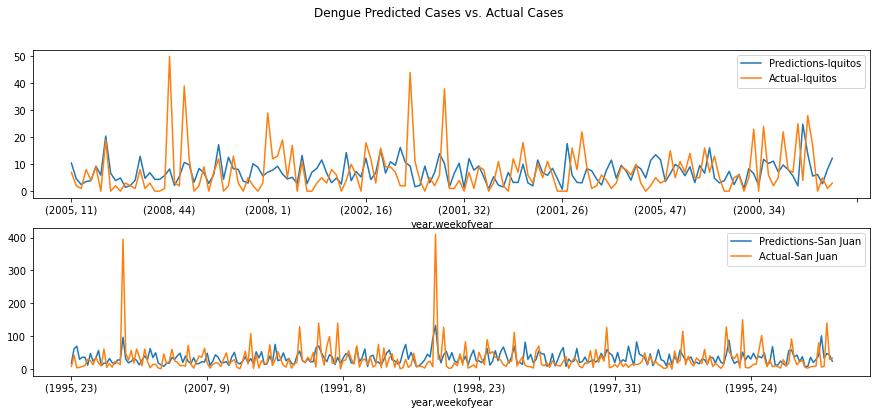

In [190]:
#Plotting the Results

figs, axes = plt.subplots(2,1, figsize=(15,6))

X_test_iq_plot = X_test_iq.copy()
X_test_sj_plot = X_test_sj.copy()

# plot sj
X_test_iq_plot['predictions'] = predictions_iq
X_test_iq_plot.predictions.plot(ax=axes[0], label="Predictions-Iquitos")
y_test_iq.plot(ax=axes[0], label="Actual-Iquitos")
axes[0].legend()

# plot iq
X_test_sj_plot['predictions'] = predictions_sj
X_test_sj_plot.predictions.plot(ax=axes[1], label="Predictions-San Juan")
y_test_sj.plot(ax=axes[1], label="Actual-San Juan")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
axes[1].legend()

In [132]:
#################################
# Fitting the Test Data Provided#
#################################

submission = pd.read_csv("submission_format.csv", index_col=[0, 1, 2])

X_submission_test_iq, X_submission_test_sj =  process(feat_df_path = 'dengue_features_test.csv',
                             labels_df_path= None,
                             standardize=True)

In [134]:
sj_predictions = best_model_sj.predict(X_submission_test_sj).astype(int)
iq_predictions = best_model_iq.predict(X_submission_test_iq).astype(int)

In [135]:
submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("poisson_model.csv")

## Let's compare our scikit-learn model to a statsmodel model

Just for practice and out of interest, I will also run a Negative Binomal Regression model using that statistical library for python, statsmodels. I prefer scikit-learn for how easy it is to tinker with everything and swap out models, but in this case it would have probably been better to do it this way. Let's compare scores to see which does better (before any feature engineering, of course).

In [203]:
formula = 'total_cases ~ ' + ' + '.join([str(i) for i in list(X_train_sj.columns)])

In [223]:
#####################################
#First, let's model the San Juan data
#####################################

sm_train_sj = X_train_sj.copy()
sm_test_sj = X_test_sj.copy()

sm_train_sj['total_cases'] = y_train_sj

model = smf.glm(formula=formula, data=sm_train_sj, family=sm.families.NegativeBinomial())
model = model.fit()

sm_predictions_train_sj = model.predict(sm_train_sj).astype(int)
print ("San Juan train error:", MAE(sm_predictions_train_sj, y_train_sj))

sm_predictions_sj = model.predict(sm_test_sj).astype(int)
print ("San Juan test error:", MAE(sm_predictions_sj, y_test_sj))


##################################
#Now, let's model the Iquitos data
##################################

sm_train_iq = X_train_iq.copy()
sm_test_iq = X_test_iq.copy()

sm_train_iq['total_cases'] = y_train_iq

model2 = smf.glm(formula=formula, data=sm_train_iq, family=sm.families.NegativeBinomial())
model2 = model2.fit()

sm_predictions_train_iq = model2.predict(sm_train_iq).astype(int)
print ("\nIquitos train error:", MAE(sm_predictions_train_iq, y_train_iq))

sm_predictions_iq = model2.predict(sm_test_iq).astype(int)
print ("Iquitos test error:", MAE(sm_predictions_iq, y_test_iq))


San Juan train error: 27.981679389312976
San Juan test error: 23.679715302491104

Iquitos train error: 6.483516483516484
Iquitos test error: 6.339743589743589


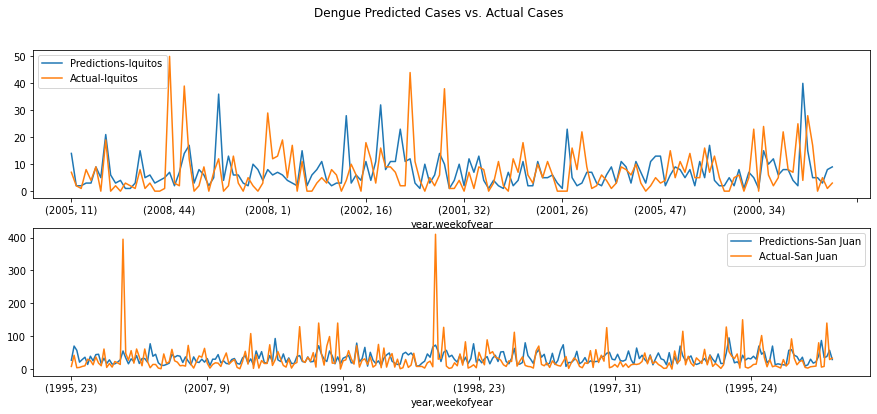

In [222]:
#Plotting the Results

figs, axes = plt.subplots(2,1, figsize=(15,6))

X_test_iq_plot2 = sm_test_iq.copy()
X_test_sj_plot2 = sm_test_sj.copy()

# plot sj
X_test_iq_plot2['predictions'] = sm_predictions_iq
X_test_iq_plot2.predictions.plot(ax=axes[0], label="Predictions-Iquitos")
y_test_iq.plot(ax=axes[0], label="Actual-Iquitos")
axes[0].legend()

# plot iq
X_test_sj_plot['predictions'] = sm_predictions_sj
X_test_sj_plot.predictions.plot(ax=axes[1], label="Predictions-San Juan")
y_test_sj.plot(ax=axes[1], label="Actual-San Juan")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
axes[1].legend()